In [328]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2

In [329]:
tumor=[]
path = './data/brain_tumor_dataset/yes/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)

healthy=[]
path = './data/brain_tumor_dataset/no/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    img = cv2.resize(img,(128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)

In [330]:
healthy = np.array(healthy)
tumor = np.array(tumor)
ALL = np.concatenate ((healthy, tumor))

In [331]:
ALL.shape


(245, 128, 128, 3)

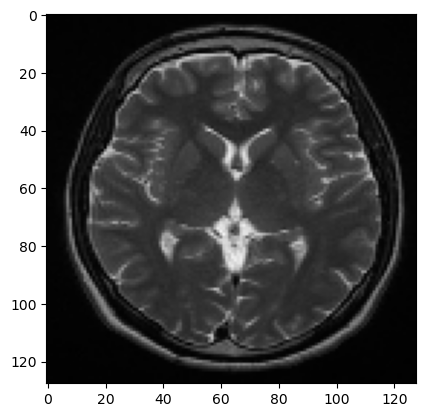

In [332]:
plt.imshow(healthy[90])

In [333]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num , replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num , replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])
    

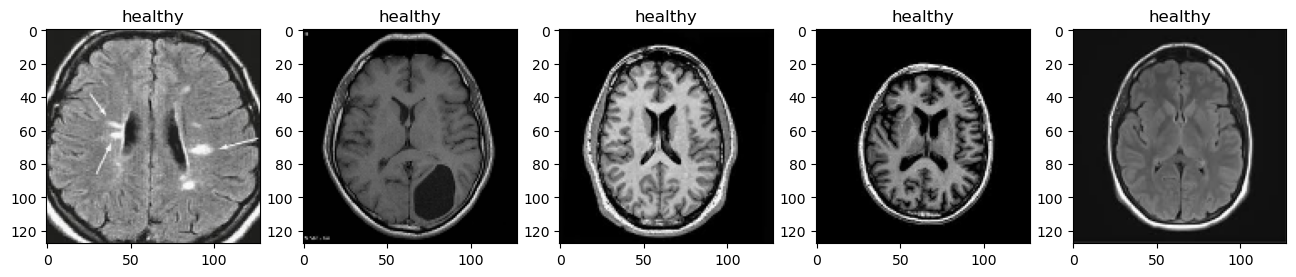

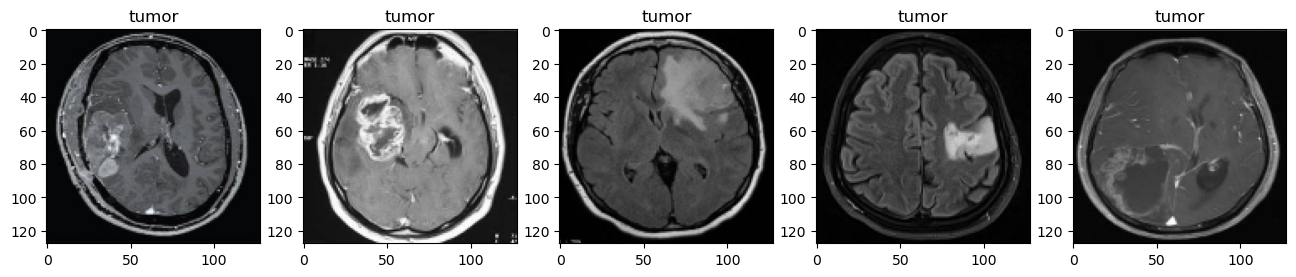

In [334]:
plot_random(healthy, tumor)

In [335]:
class Dataset(object):
    def __getitem__(self, index):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
    def __add__(self,other):
        return ConcatDataset([self, other])


In [336]:
class MRI(Dataset):
    def __init__(self):
        
        tumor=[]
        healthy=[]
        
        for f in glob.iglob('./data/brain_tumor_dataset/yes/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))#otherwise the shape will be(h,w,#channels)
            tumor.append(img)
            
        
        for f in glob.iglob('./data/brain_tumor_dataset/no/*.jpg'):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))#otherwise the shape will be(h,w,#channels)
            healthy.append(img)
            
        #our images
        tumor = np.array(tumor,dtype= np.float32)
        healthy = np.array(healthy,dtype= np.float32)

        #our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        #concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np. concatenate((tumor_label, healthy_label))

    def __len__(self):
        return self.images.shape[0]
        
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample 

    def normalize(self):
        self.images = self.images/255.0





In [337]:
mri_dataset = MRI()

In [338]:
mri_dataset.normalize()


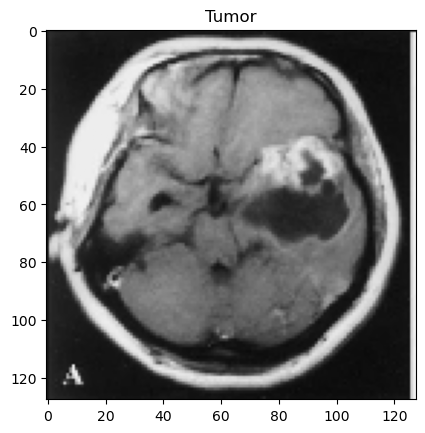

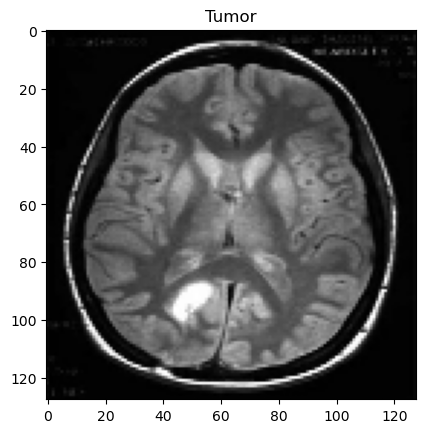

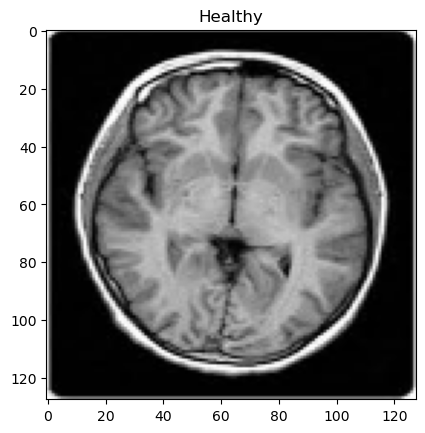

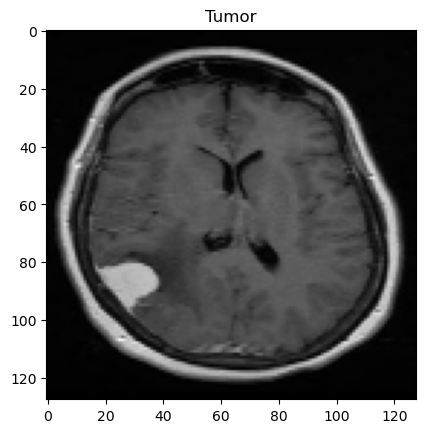

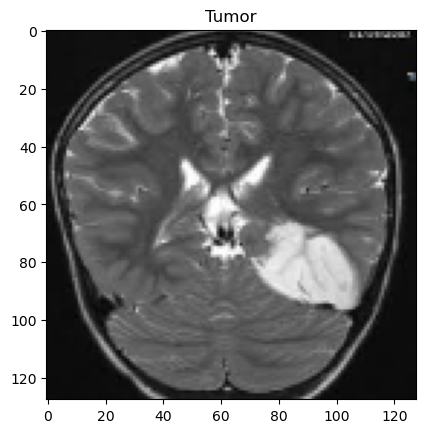

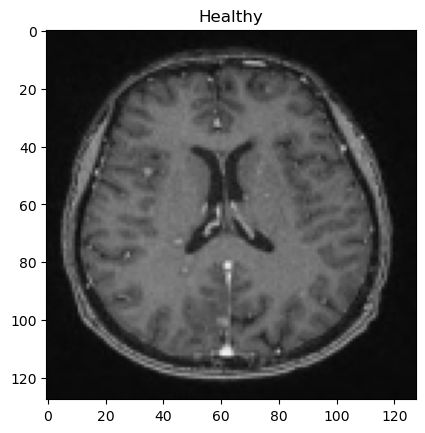

In [339]:
names={0:'Healthy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    
    img = sample['image'].squeeze()#squeeze to remove the first demention
    img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i==5:
        break

In [340]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.ReLU(),
        nn.Dropout2d(0.2),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.ReLU(),
        nn.Dropout2d(0.2),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(in_features=120, out_features=84),
        nn.ReLU(),
        nn.Dropout(0.7),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x


In [341]:

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available.")

GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU


In [342]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0')
model = CNN().to(device)

In [343]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [344]:
model.eval()
outputs = []
y_true = []

with torch.no_grad():
    
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)
    
        y_hat = model(image)
    
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
    

In [345]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [346]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [347]:
accuracy_score(y_true, threshold(outputs))

0.37142857142857144

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

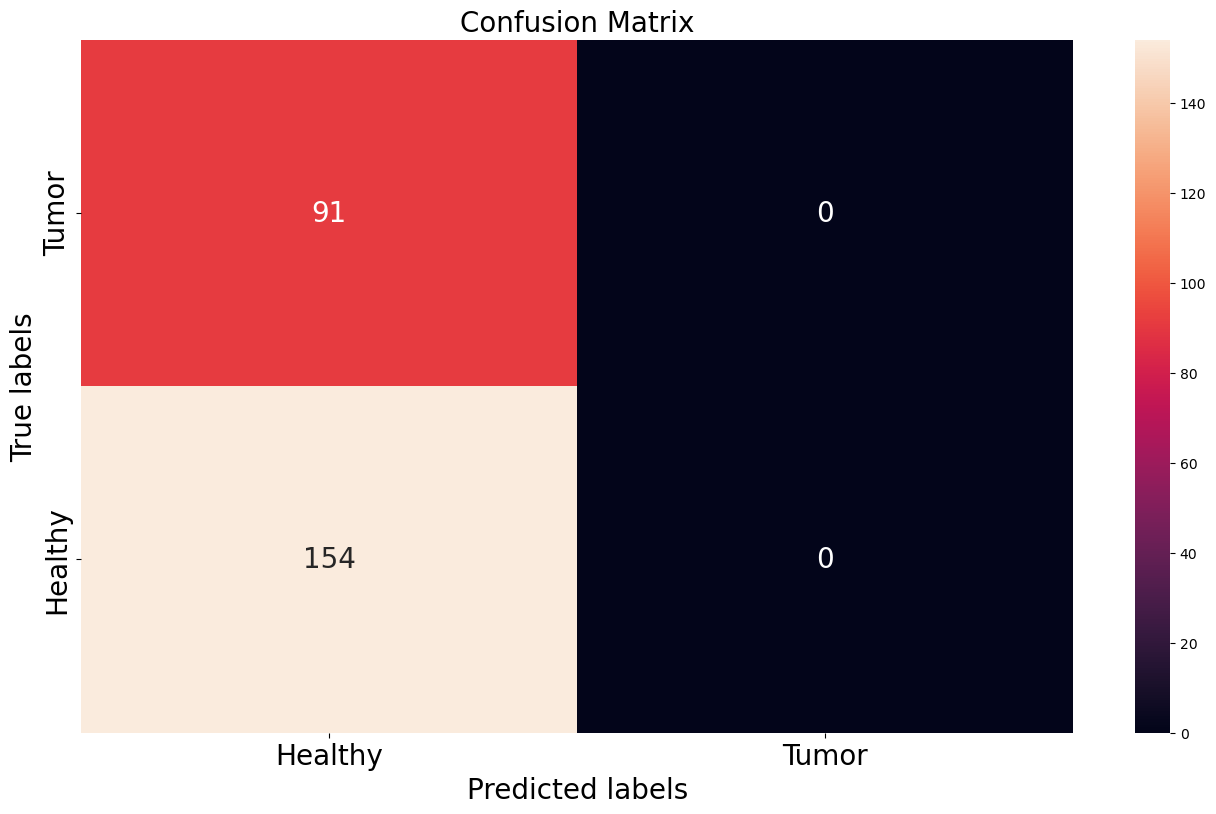

In [348]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

In [392]:
eta = 0.001 #learning rate
EPOCH = 300
optimizer = torch.optim.Adam(model.parameters(), lr=eta, weight_decay=1e-5)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()


CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Dropout2d(p=0.2, inplace=False)
    (3): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): Dropout2d(p=0.2, inplace=False)
    (7): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=False)
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.7, inplace=False)
    (6): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [393]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        error = nn.BCELoss()
        # define loss fun
        loss = torch.sum(error(y_hat.squeeze(),label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if(epoch+1)%10 == 0:
        print('train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

train Epoch: 10	Loss: 0.009242
train Epoch: 20	Loss: 0.007859
train Epoch: 30	Loss: 0.003867
train Epoch: 40	Loss: 0.010613
train Epoch: 50	Loss: 0.000572
train Epoch: 60	Loss: 0.000113
train Epoch: 70	Loss: 0.000557
train Epoch: 80	Loss: 0.000389
train Epoch: 90	Loss: 0.008349
train Epoch: 100	Loss: 0.008196
train Epoch: 110	Loss: 0.006718
train Epoch: 120	Loss: 0.007797
train Epoch: 130	Loss: 0.002443
train Epoch: 140	Loss: 0.001849
train Epoch: 150	Loss: 0.000679
train Epoch: 160	Loss: 0.006730
train Epoch: 170	Loss: 0.000187
train Epoch: 180	Loss: 0.001242
train Epoch: 190	Loss: 0.000351
train Epoch: 200	Loss: 0.000153
train Epoch: 210	Loss: 0.000287
train Epoch: 220	Loss: 0.003415
train Epoch: 230	Loss: 0.003242
train Epoch: 240	Loss: 0.000444
train Epoch: 250	Loss: 0.001242
train Epoch: 260	Loss: 0.000063
train Epoch: 270	Loss: 0.000384
train Epoch: 280	Loss: 0.001367
train Epoch: 290	Loss: 0.111751
train Epoch: 300	Loss: 0.015551


In [394]:
model.eval()
dataloader= DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs = []
y_true = []

with torch.no_grad():
    
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)
    
        y_hat = model(image)
    
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate(outputs, axis=0)
y_true = np.concatenate(y_true, axis=0)

In [395]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

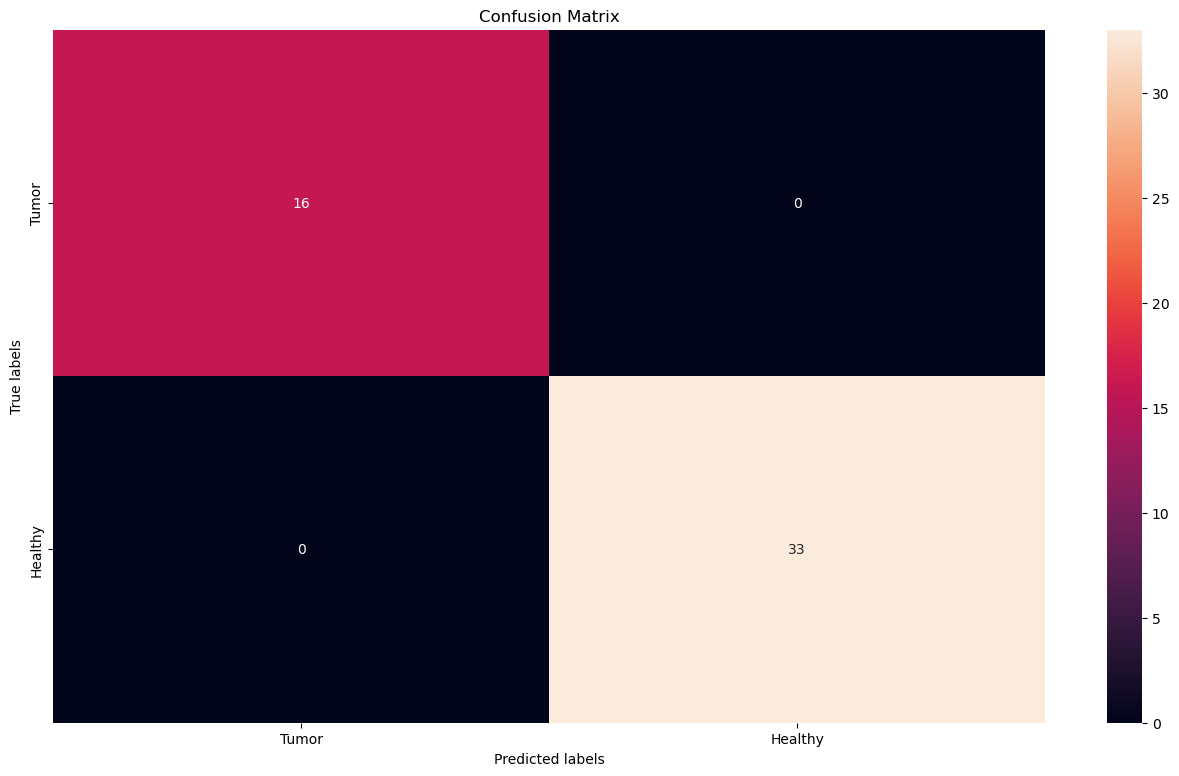

In [396]:
#confusion matrix
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

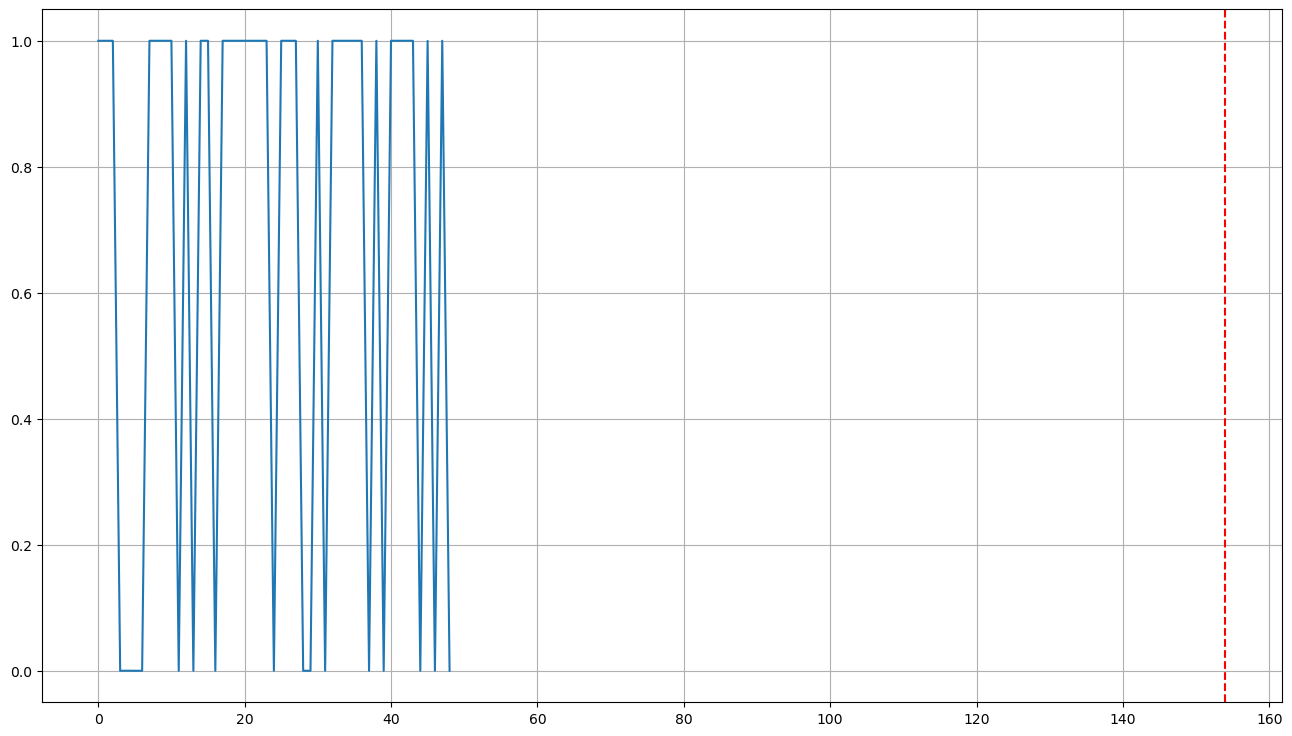

In [397]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

In [398]:
no_of_layers = 0
conv_layers = []

In [399]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): ReLU()
   (2): Dropout2d(p=0.2, inplace=False)
   (3): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (5): ReLU()
   (6): Dropout2d(p=0.2, inplace=False)
   (7): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): ReLU()
   (2): Dropout(p=0.7, inplace=False)
   (3): Linear(in_features=120, out_features=84, bias=True)
   (4): ReLU()
   (5): Dropout(p=0.7, inplace=False)
   (6): Linear(in_features=84, out_features=1, bias=True)
 )]

In [400]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [401]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

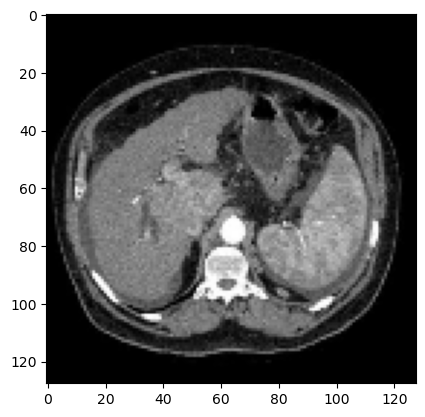

In [404]:
img = mri_dataset[40]['image']
plt.imshow(img.reshape(128,128,3))

In [405]:
img = torch.from_numpy(img).to(device)

In [406]:
img.shape


torch.Size([3, 128, 128])

In [407]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [408]:
results = [conv_layers[0](img)]#takes 1 img and shows convulutional layers
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
    #in results[-1] grabs the last feature map of first conv layer
outputs = results

Layer  1


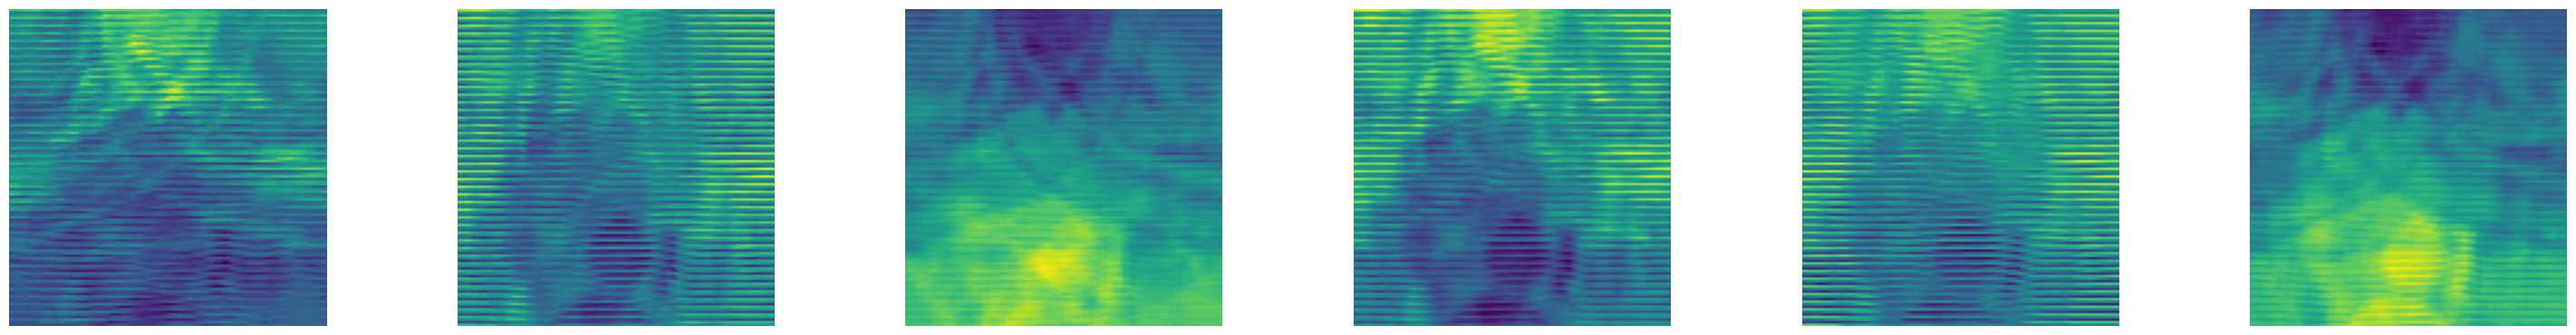

Layer  2


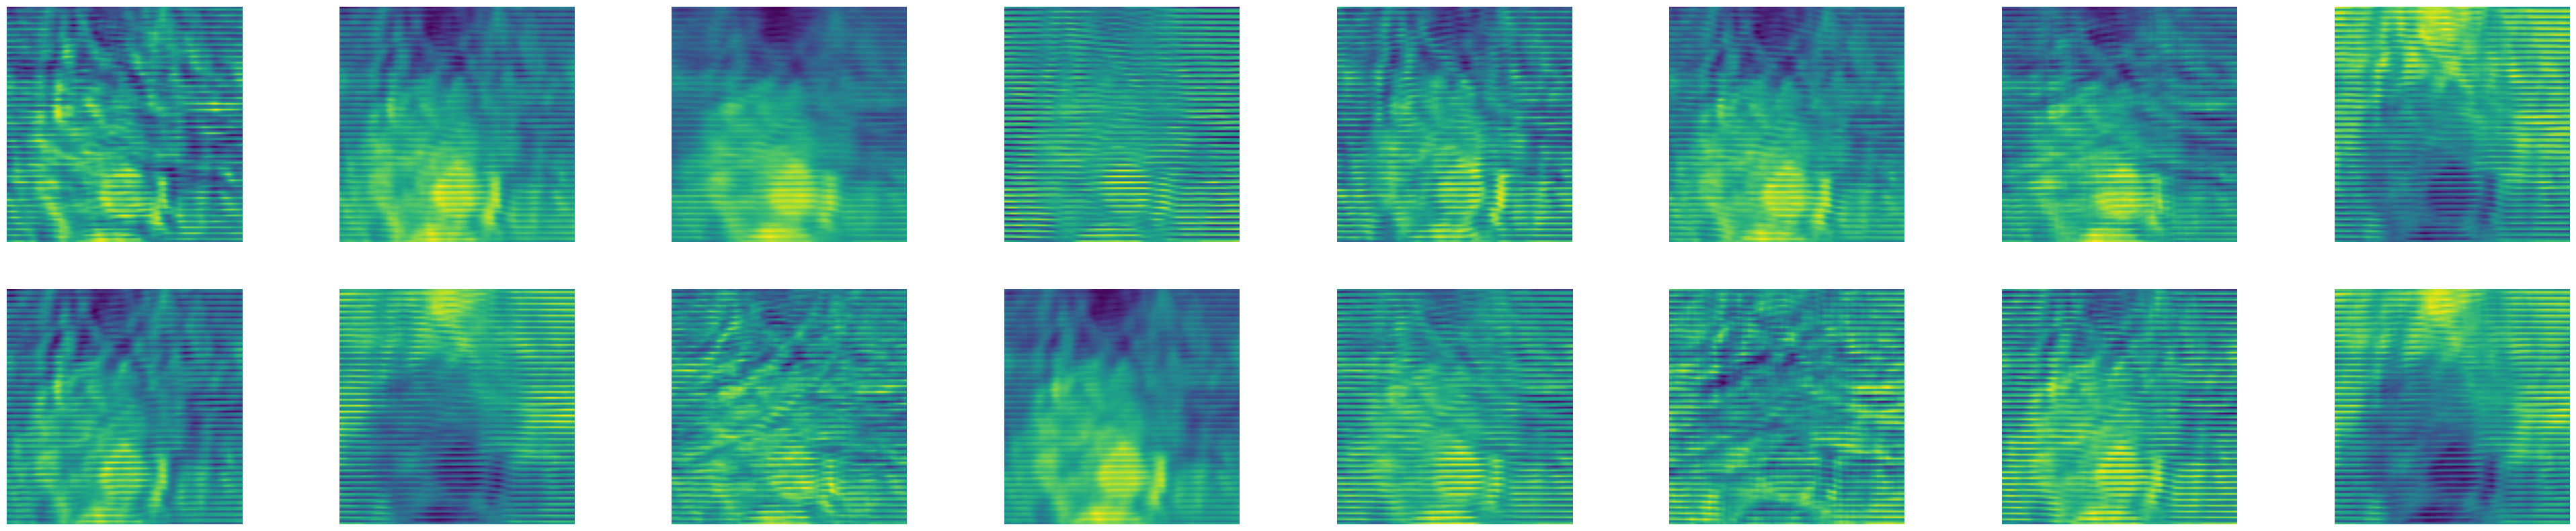

In [409]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

In [410]:
from sklearn.model_selection import train_test_split

In [411]:
class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [412]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [413]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [414]:
device = torch.device("cuda:0")
model = CNN().to(device)

In [415]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [416]:
# keep track of epoch losses

epoch_train_loss = []
epoch_val_loss = []

In [417]:
for epoch in range(1,400):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))

Train Epoch: 10	Train Loss: 0.692679	Val Loss: 0.687853
Train Epoch: 20	Train Loss: 0.666570	Val Loss: 0.628489
Train Epoch: 30	Train Loss: 0.651331	Val Loss: 0.599598
Train Epoch: 40	Train Loss: 0.625113	Val Loss: 0.598755
Train Epoch: 50	Train Loss: 0.621544	Val Loss: 0.596736
Train Epoch: 60	Train Loss: 0.684681	Val Loss: 0.590704
Train Epoch: 70	Train Loss: 0.625391	Val Loss: 0.586380
Train Epoch: 80	Train Loss: 0.595844	Val Loss: 0.591685
Train Epoch: 90	Train Loss: 0.664495	Val Loss: 0.587190
Train Epoch: 100	Train Loss: 0.609283	Val Loss: 0.588574
Train Epoch: 110	Train Loss: 0.647464	Val Loss: 0.583809
Train Epoch: 120	Train Loss: 0.593132	Val Loss: 0.584873
Train Epoch: 130	Train Loss: 0.636363	Val Loss: 0.583854
Train Epoch: 140	Train Loss: 0.631779	Val Loss: 0.575848
Train Epoch: 150	Train Loss: 0.656070	Val Loss: 0.566756
Train Epoch: 160	Train Loss: 0.588317	Val Loss: 0.569218
Train Epoch: 170	Train Loss: 0.618716	Val Loss: 0.566046
Train Epoch: 180	Train Loss: 0.630173	Va

Text(0, 0.5, 'Loss')

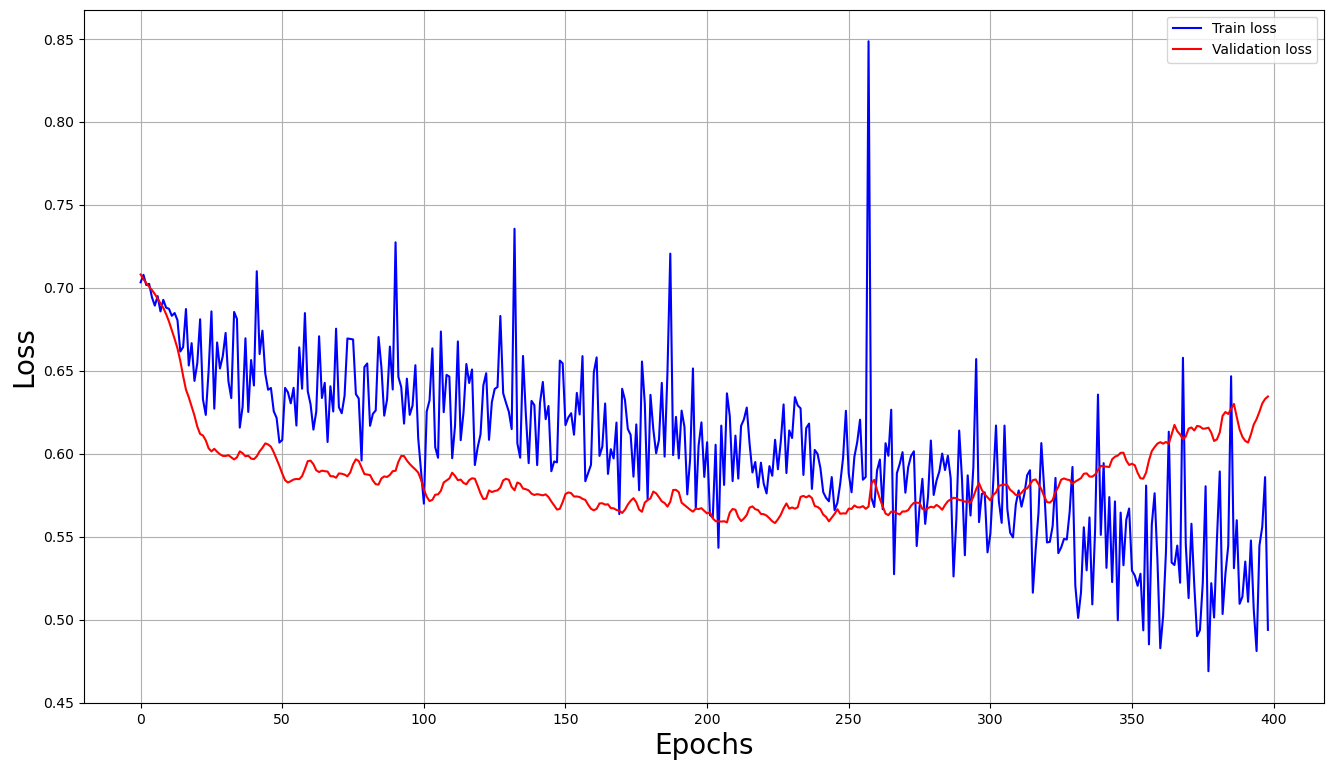

In [418]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)